# Detecting Pitch Accuracy with Harmonies

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa.display

We will be using Fur Elise for this notebook. We start by defining a multi-dimentional state model for this song.

In [9]:
bpm_ref = 60.0 / 0.44

S_b = 0.5
E_b = 1.0

E5  = 76
DS5 = 75
B4  = 71
D5  = 74
C5  = 72
A4  = 69
C4  = 60
E4  = 64
GS4 = 68

fur_elise_pitches = [
    # Phrase 1
    E5, DS5, E5, DS5, E5, B4, D5, C5, A4,
    C4, E4, A4, B4,
    E4, GS4, B4, C5,
    E4,
    # Phrase 1 Repeat (variation at end)
    E5, DS5, E5, DS5, E5, B4, D5, C5, A4,
    C4, E4, A4, B4,
    E4, C5, B4, A4,
]

fur_elise_beats = [
    # Phrase 1
    S_b, S_b, S_b, S_b, S_b, S_b, S_b, S_b, E_b,
    S_b, S_b, S_b, E_b,
    S_b, S_b, S_b, E_b,
    S_b,
    # Phrase 1 Repeat (variation at end)
    S_b, S_b, S_b, S_b, S_b, S_b, S_b, S_b, E_b,
    S_b, S_b, S_b, E_b,
    S_b, S_b, S_b, E_b,
]

In [5]:
A2  = 45
E2  = 40
E3  = 52
A3  = 57
GS3 = 56

fur_elise_harmony_pitches = [
    0,           # rest intro
    A2, E3, A3,  # Am arpeggio
    E2, E3, GS3, # E major-ish arpeggio
    A2, E3, A3,  # Am turnaround
    0,           # repeat intro (shortened)
    A2, E3, A3,  # Am arpeggio
    E2, E3, GS3, A2,  # ending phrase
]

fur_elise_harmony_beats = [
    4.0,         # 1.76s
    S_b, S_b, 3*S_b,
    S_b, S_b, 3*S_b,
    S_b, S_b, 3*S_b,
    4.0 - 3*S_b, # 1.76 - 0.66 = 1.10s => 2.5 beats
    S_b, S_b, 3*S_b,
    S_b, S_b, 3*S_b, E_b,
]

In [3]:
def combine_tracks_to_segments(mel_pitches, mel_beats, harm_pitches, harm_beats):
    """
    Returns segments: list of (pitches_tuple, dur_beats)
    pitches_tuple is sorted and contains only >0 MIDI pitches.
    """
    i = j = 0
    rem_m = mel_beats[0]
    rem_h = harm_beats[0]
    cur_m = mel_pitches[0]
    cur_h = harm_pitches[0]

    segments = []

    while i < len(mel_pitches) and j < len(harm_pitches):
        dt = min(rem_m, rem_h)

        pitches = tuple(sorted([p for p in (cur_m, cur_h) if p and p > 0]))
        segments.append((pitches, dt))

        rem_m -= dt
        rem_h -= dt

        if rem_m <= 1e-9:
            i += 1
            if i >= len(mel_pitches): break
            cur_m = mel_pitches[i]
            rem_m = mel_beats[i]

        if rem_h <= 1e-9:
            j += 1
            if j >= len(harm_pitches): break
            cur_h = harm_pitches[j]
            rem_h = harm_beats[j]

    # Optional: merge adjacent identical pitch-sets
    merged = []
    for ps, b in segments:
        if merged and merged[-1][0] == ps:
            merged[-1] = (ps, merged[-1][1] + b)
        else:
            merged.append((ps, b))
    
    return merged

In [8]:
fur_elise_segments = combine_tracks_to_segments(
    fur_elise_pitches, fur_elise_beats,
    fur_elise_harmony_pitches, fur_elise_harmony_beats
)

combo_pitches = [ps for ps, b in fur_elise_segments]
combo_beats   = [b  for ps, b in fur_elise_segments]

#### Utility functions (carried over from HMM.ipynb)

In [32]:
def mp3_to_cqt_db(audio_path, sr=22050, hop_length=512,
                  fmin=librosa.note_to_hz("C2"), n_bins=84, bins_per_octave=12):
    y, sr_used = librosa.load(audio_path, sr=sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=35)

    C = librosa.cqt(y=y, sr=sr_used, hop_length=hop_length,
                    fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave)
    C_mag = np.abs(C)
    X_db = librosa.amplitude_to_db(C_mag, ref=np.max)     # (n_bins, T)
    return X_db, y, sr_used

def dt_ms_from_cqt(sr, hop_length):
    return 1000.0 * hop_length / sr

def viterbi_ASR(A, pi, B, on01=None, is_attack=None, bonus=2.0):

    S, T = B.shape
    logA  = np.where(A > 0, np.log(A), -np.inf)
    logpi = np.where(pi > 0, np.log(pi), -np.inf)

    dp = np.full((S, T), -np.inf)
    bp = np.zeros((S, T), dtype=int)

    dp[:, 0] = logpi + B[:, 0]

    use_bonus = (on01 is not None) and (is_attack is not None)
    if use_bonus:
        is_attack = np.asarray(is_attack, dtype=bool)
        is_nonattack = ~is_attack

    for t in range(1, T):
        if use_bonus:
            logA_t = logA.copy()

            # add bonus ONLY to transitions from NON-ATTACK -> ATTACK
            # (this encourages *entering* attack near onset peaks)
            logA_t[np.ix_(is_nonattack, is_attack)] += bonus * on01[t]
        else:
            logA_t = logA

        for s in range(S):
            prev = dp[:, t-1] + logA_t[:, s]
            pbest = int(np.argmax(prev))
            dp[s, t] = prev[pbest] + B[s, t]
            bp[s, t] = pbest

    last = int(np.argmax(dp[:, -1]))
    path = np.zeros(T, dtype=int)
    path[-1] = last
    for t in range(T-1, 0, -1):
        path[t-1] = bp[path[t], t]

    return path, dp

def plot_state_path(path, sr, hop_length, title="Viterbi decoded state vs time"):
    T = len(path)
    times = np.arange(T) * hop_length / sr
    plt.figure(figsize=(14, 3))
    plt.step(times, path, where="post")
    plt.xlabel("Time (s)")
    plt.ylabel("State index")
    plt.title(title)
    plt.yticks(range(int(path.max()) + 1))
    plt.tight_layout()
    plt.show()

def onset_strength_envelope(y, sr, hop_length):
    o = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    o = o.astype(float)
    o -= o.min()
    o /= (o.max() + 1e-9)
    return o

def silence_template(n_bins):
    # simple: uniform low template (after column-normalization in emissions, this acts like "no strong pitch")
    tpl = np.ones(n_bins, float)
    tpl /= (np.linalg.norm(tpl) + 1e-9)
    return tpl

def midi_to_hz(m): 
    return 440.0 * (2.0 ** ((m - 69) / 12.0))

def hz_to_cqt_bin(hz, fmin, bins_per_octave):
    return int(np.round(bins_per_octave * np.log2(hz / fmin)))

def emissions_cosine(C, TPL, scale=1.0):
    C = C - C.mean(axis=0, keepdims=True)
    C /= (np.linalg.norm(C, axis=0, keepdims=True) + 1e-9)
    scores = TPL @ C          # (S, T) cosine similarity-ish
    B = scale * scores         # treat as log-likelihood scores
    return B, scores

In [23]:
PHASES = ["A","S","R"]

def build_ASR_states_segments(segments, bpm_ref, dt_ms,
                             frac_attack=0.15, frac_release=0.15,
                             min_A=1, min_S=1, min_R=1,
                             p_start_to_first=0.02,
                             end_selfloop=True,
                             tempo_slack=1.02,
                             T_total=None):
    ms_per_beat = 60000.0 / bpm_ref
    frames_per_beat = ms_per_beat / dt_ms

    # compute nominal frames per segment
    seg_steps = []
    for pitchset, dur_beats in segments:
        Tn = max(1, int(round(dur_beats * frames_per_beat)))
        seg_steps.append(Tn)

    # build states (START + 3 per segment)
    states = [{"seg_idx": -1, "pitches": (), "phase": "START", "dur_steps": None}]
    for i, ((pitchset, _), Tn) in enumerate(zip(segments, seg_steps)):
        Ta = max(min_A, int(round(frac_attack * Tn)))
        Tr = max(min_R, int(round(frac_release * Tn)))
        Ts = max(min_S, Tn - Ta - Tr)

        for ph, Td in zip(PHASES, [Ta, Ts, Tr]):
            states.append({"seg_idx": i, "pitches": tuple(pitchset), "phase": ph, "dur_steps": Td})

    S = len(states)
    A = np.zeros((S, S), float)

    def idx(seg_i, phase):  # segment i -> state index (shifted by START)
        base = 1 + 3 * seg_i
        return base + PHASES.index(phase)

    start = 0
    first_attack = idx(0, "A")

    A[start, start] = 1.0 - p_start_to_first
    A[start, first_attack] = p_start_to_first

    N = len(segments)
    for seg_i in range(N):
        a = idx(seg_i, "A"); s = idx(seg_i, "S"); r = idx(seg_i, "R")

        def set_geometric(from_state, to_state, expected_frames, slack=1.0):
            expected = max(1, int(round(expected_frames * slack)))
            p_adv = 1.0 / expected
            A[from_state, from_state] = 1.0 - p_adv
            A[from_state, to_state]   = p_adv

        set_geometric(a, s, states[a]["dur_steps"], slack=tempo_slack)
        set_geometric(s, r, states[s]["dur_steps"], slack=tempo_slack)

        if seg_i < N - 1:
            a_next = idx(seg_i + 1, "A")
            set_geometric(r, a_next, states[r]["dur_steps"], slack=tempo_slack)
        else:
            A[r, r] = 1.0 if end_selfloop else 1.0

    pi = np.zeros(S, float)
    pi[start] = 1.0
    return states, A, pi


Note template CQT -> chord template CQT

In [28]:
def chord_template_cqt(pitches, fmin, n_bins, bins_per_octave, window=1):
    tpl = np.zeros(n_bins, dtype=float)
    for midi in pitches:
        tpl += note_template_cqt(midi, fmin, n_bins, bins_per_octave, window=window)
    tpl /= (np.linalg.norm(tpl) + 1e-9)
    return tpl

def note_template_cqt(midi, fmin, n_bins, bins_per_octave, window=1):
    tpl = np.zeros(n_bins, float)
    f0 = midi_to_hz(midi)

    # harmonic weights
    harm_w = {1:1.0, 2:0.6, 3:0.4, 4:0.25}
    for h, w in harm_w.items():
        k = hz_to_cqt_bin(h*f0, fmin, bins_per_octave)
        for kk in range(k-window, k+window+1):
            if 0 <= kk < n_bins:
                tpl[kk] += w

    tpl /= (np.linalg.norm(tpl) + 1e-9)
    return tpl

In [25]:
def build_ASR_templates_segments(states, fmin, n_bins, bins_per_octave, window=1):
    sil = silence_template(n_bins)
    TPL = []
    for st in states:
        if st["phase"] in ("A","S"):
            TPL.append(chord_template_cqt(st["pitches"], fmin, n_bins, bins_per_octave, window=window))
        else:
            TPL.append(sil)
    return np.stack(TPL, axis=0)

In [34]:
def emissions_ASR(C_db, TPL, onset01, states, scale_pitch=2.0, w_attack_onset=2.0, w_sustain_onset=-0.5, w_release_onset=-1.0, w_release_energy=-0.5):
    B_base, scores = emissions_cosine(C_db, TPL, scale=scale_pitch)  # (S,T)

    S, T = B_base.shape
    o = onset01[:T]
    if len(o) < T:
        o = np.pad(o, (0, T-len(o)), mode="edge")

    # crude "energy" from CQT (in dB); higher = louder
    # use column-wise mean as a simple energy proxy
    energy = C_db.mean(axis=0)  # (T,)
    # normalize to roughly [-1, 1]
    energy = (energy - energy.mean()) / (energy.std() + 1e-9)

    B = B_base.copy()
    for s in range(S):
        ph = states[s]["phase"]
        if ph == "A":
            B[s, :] += w_attack_onset * o
        elif ph == "S":
            B[s, :] += w_sustain_onset * o
        else:  # "R"
            B[s, :] += w_release_onset * o
            B[s, :] += w_release_energy * energy

    return B, scores


/var/folders/_g/r_5kzcvn6f59ld2yfw2jrl2w0000gn/T/ipykernel_6234/3351285690.py:18: RuntimeWarning: divide by zero encountered in log
  logA  = np.where(A > 0, np.log(A), -np.inf)
/var/folders/_g/r_5kzcvn6f59ld2yfw2jrl2w0000gn/T/ipykernel_6234/3351285690.py:19: RuntimeWarning: divide by zero encountered in log
  logpi = np.where(pi > 0, np.log(pi), -np.inf)


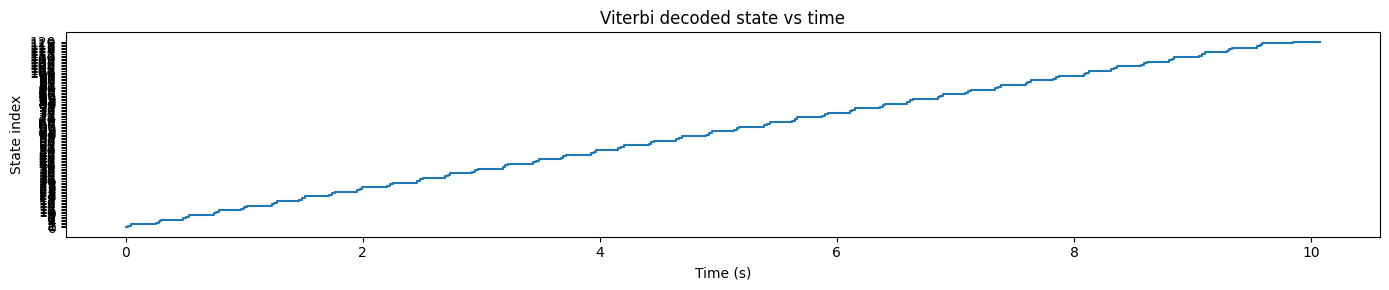

In [35]:
mp3_path = "tests/piano-synth/target_music/fur_elise_harmony_slow.mp3"
segments = list(zip(combo_pitches, combo_beats))
C, y, sr = mp3_to_cqt_db(mp3_path, sr=22050, hop_length=512)
dt_ms = dt_ms_from_cqt(sr, hop_length=512)
onset_env = onset_strength_envelope(y, sr, hop_length=512)

states, A, pi = build_ASR_states_segments(segments, bpm_ref, dt_ms,
                                         frac_attack=0.15, frac_release=0.15,
                                         min_A=1, min_S=1, min_R=1,
                                         p_start_to_first=0.02,
                                         end_selfloop=True,
                                         tempo_slack=1.02)
TPL = build_ASR_templates_segments(states, fmin=librosa.note_to_hz("C2"), n_bins=84, bins_per_octave=12, window=1)
B, scores = emissions_ASR(C, TPL, onset_env, states, scale_pitch=2.0, w_attack_onset=2.0, w_sustain_onset=-0.5, w_release_onset=-1.0, w_release_energy=-0.5)
path, dp = viterbi_ASR(A, pi, B, on01=onset_env, is_attack=[st["phase"]=="A" for st in states], bonus=2.0)
plot_state_path(path, sr, hop_length=512, title="Viterbi decoded state vs time")

In [51]:
def plot_spec_with_attack_boundaries(
    C, sr, hop_length,
    path, states,
    title="Spectrogram + decoded NOTE boundaries (attack starts)",
    y_axis="cqt_hz",
    note_key_priority=("note_idx", "seg_idx", "segment_idx")
):
    T = C.shape[1]
    path = np.asarray(path)[:T]

    # pick whatever key exists for "note identity"
    def get_note_id(st):
        for k in note_key_priority:
            if k in st:
                return st[k]
        return -999  # fallback

    note_id = np.array([get_note_id(states[s]) for s in path], dtype=int)
    phase   = np.array([states[s]["phase"] for s in path])

    # attack-start frames: entering an Attack state (not just "being in A")
    enter_attack = (phase == "A") & np.r_[True, phase[1:] != phase[:-1]]

    # note boundary = note id changed
    note_change = np.r_[True, note_id[1:] != note_id[:-1]]

    boundary_frames = np.where(enter_attack & note_change)[0]

    plt.figure(figsize=(14, 5))
    librosa.display.specshow(C, sr=sr, hop_length=hop_length,
                             x_axis="time", y_axis=y_axis)
    plt.title(title)
    plt.colorbar(format="%+2.0f dB")

    for f in boundary_frames:
        t_sec = librosa.frames_to_time(f, sr=sr, hop_length=hop_length)
        plt.axvline(t_sec, linewidth=2)

    plt.tight_layout()
    plt.show()
    return boundary_frames


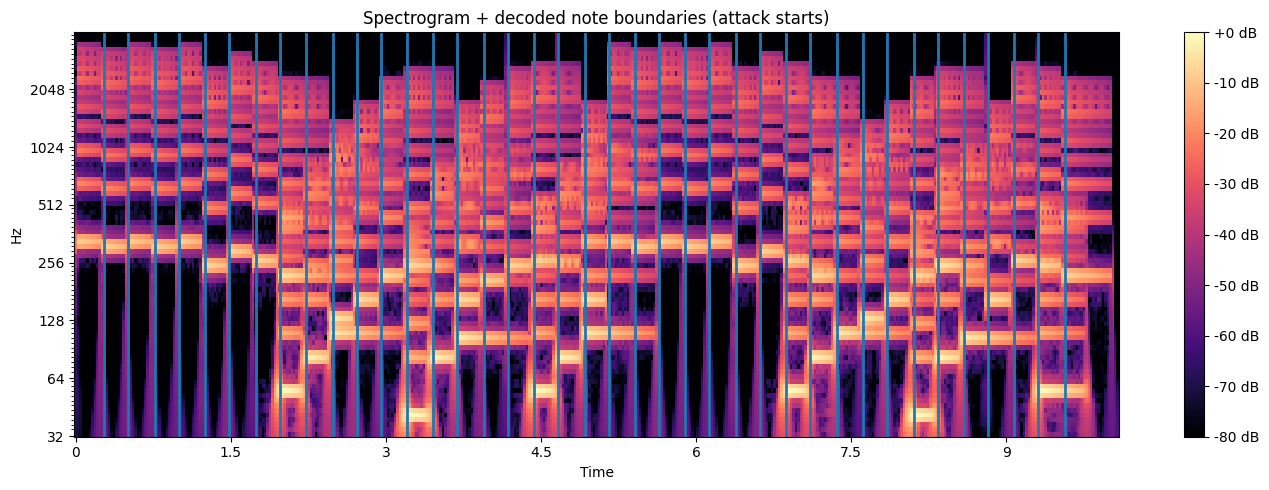

array([ 12,  22,  33,  43,  54,  64,  75,  85,  96, 107, 117, 127, 138,
       149, 159, 170, 180, 191, 201, 212, 222, 233, 243, 254, 264, 275,
       285, 296, 306, 317, 328, 338, 349, 359, 370, 380, 391, 401, 412])

In [39]:
plot_spec_with_attack_boundaries_segmented(C, sr, hop_length=512, path=path, states=states,
    title="Spectrogram + decoded note boundaries (attack starts)", y_axis="cqt_hz")

### Test with Ode to Joy

In [40]:
E_b = 1.0   # eighth note in beats
Q_b = 2.0   # quarter note in beats

# MIDI pitches
E4 = 64
F4 = 65
G4 = 67
D4 = 62
C4 = 60
C3 = 48
G3 = 55

ode_melody_pitches = [
    E4, E4, F4, G4, G4, F4, E4, D4,
    C4, C4, D4, E4, E4, D4, D4
]

ode_melody_beats = [
    E_b, E_b, E_b, E_b, E_b, E_b, E_b, E_b,
    E_b, E_b, E_b, E_b, 1.5*E_b, 0.5*E_b, Q_b
]

ode_harmony_pitches = [
    C3, G3, C3, G3
]

ode_harmony_beats = [
    4.0*E_b, 4.0*E_b, 4.0*E_b, 4.0*E_b
]

In [41]:
ode_segments = combine_tracks_to_segments(
    ode_melody_pitches, ode_melody_beats,
    ode_harmony_pitches, ode_harmony_beats
)

combo_pitches = [ps for ps, b in ode_segments]
combo_beats   = [b  for ps, b in ode_segments]

/var/folders/_g/r_5kzcvn6f59ld2yfw2jrl2w0000gn/T/ipykernel_6234/3351285690.py:18: RuntimeWarning: divide by zero encountered in log
  logA  = np.where(A > 0, np.log(A), -np.inf)
/var/folders/_g/r_5kzcvn6f59ld2yfw2jrl2w0000gn/T/ipykernel_6234/3351285690.py:19: RuntimeWarning: divide by zero encountered in log
  logpi = np.where(pi > 0, np.log(pi), -np.inf)


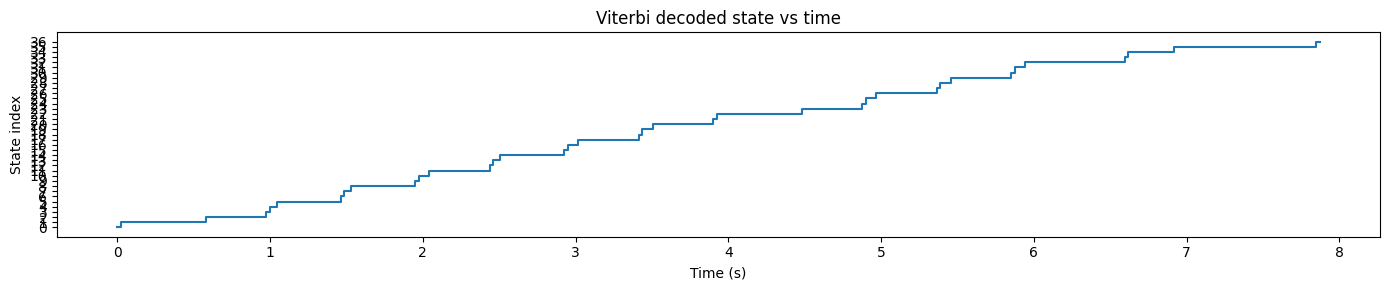

In [54]:
mp3_path = "tests/piano-synth/target_music/ode_to_joy_harmony_slow.mp3"
segments = list(zip(combo_pitches, combo_beats))
C, y, sr = mp3_to_cqt_db(mp3_path, sr=22050, hop_length=512)
dt_ms = dt_ms_from_cqt(sr, hop_length=512)
onset_env = onset_strength_envelope(y, sr, hop_length=512)
states, A, pi = build_ASR_states_segments(segments, bpm_ref, dt_ms,
                                         frac_attack=0.15, frac_release=0.15,
                                         min_A=1, min_S=1, min_R=1,
                                         p_start_to_first=0.02,
                                         end_selfloop=True,
                                         tempo_slack=1.02)
TPL = build_ASR_templates_segments(states, fmin=librosa.note_to_hz("C2"), n_bins=84, bins_per_octave=12, window=1)
B, scores = emissions_ASR(C, TPL, onset_env, states, scale_pitch=2.0, w_attack_onset=4.0, w_sustain_onset=-0.8, w_release_onset=-1.0, w_release_energy=-0.5)
path, dp = viterbi_ASR(A, pi, B, on01=onset_env, is_attack=[st["phase"]=="A" for st in states], bonus=2.0)
plot_state_path(path, sr, hop_length=512, title="Viterbi decoded state vs time")

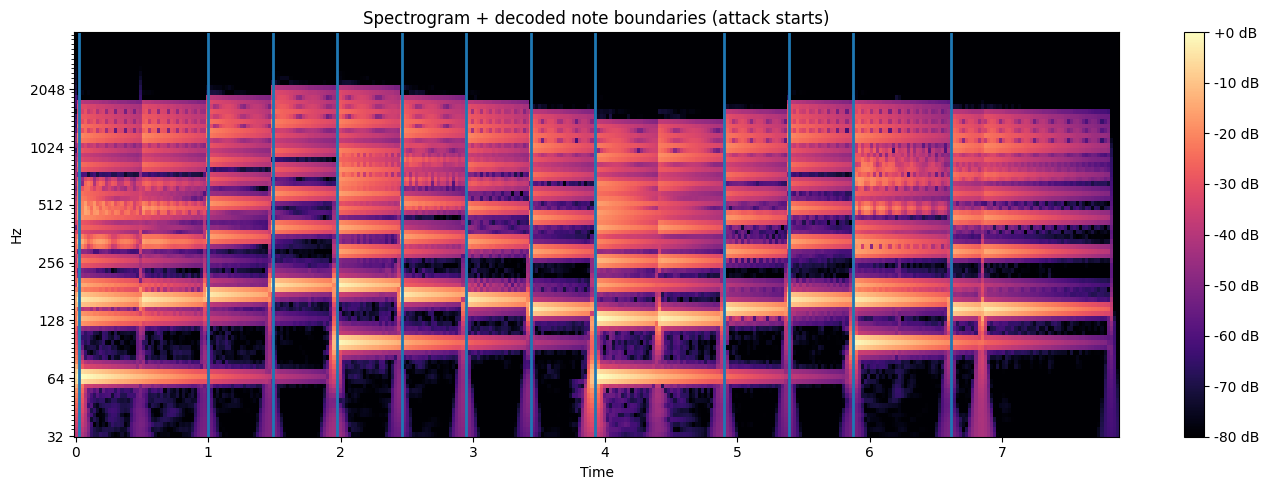

array([  1,  43,  64,  85, 106, 127, 148, 169, 211, 232, 253, 285])

In [55]:
plot_spec_with_attack_boundaries(C, sr, hop_length=512, path=path, states=states,
    title="Spectrogram + decoded note boundaries (attack starts)", y_axis="cqt_hz")

In [57]:
def plot_spec_with_state_switches(C, sr, hop_length, path, title="Spec + STATE switches", y_axis="cqt_hz"):
    path = np.asarray(path)
    T = min(C.shape[1], len(path))
    path = path[:T]

    switch_frames = np.where(np.r_[True, path[1:] != path[:-1]])[0]

    plt.figure(figsize=(14,5))
    librosa.display.specshow(C[:, :T], sr=sr, hop_length=hop_length, x_axis="time", y_axis=y_axis)
    plt.title(title)
    plt.colorbar(format="%+2.0f dB")
    for f in switch_frames:
        plt.axvline(librosa.frames_to_time(f, sr=sr, hop_length=hop_length), linewidth=2)
    plt.tight_layout()
    plt.show()

    return switch_frames

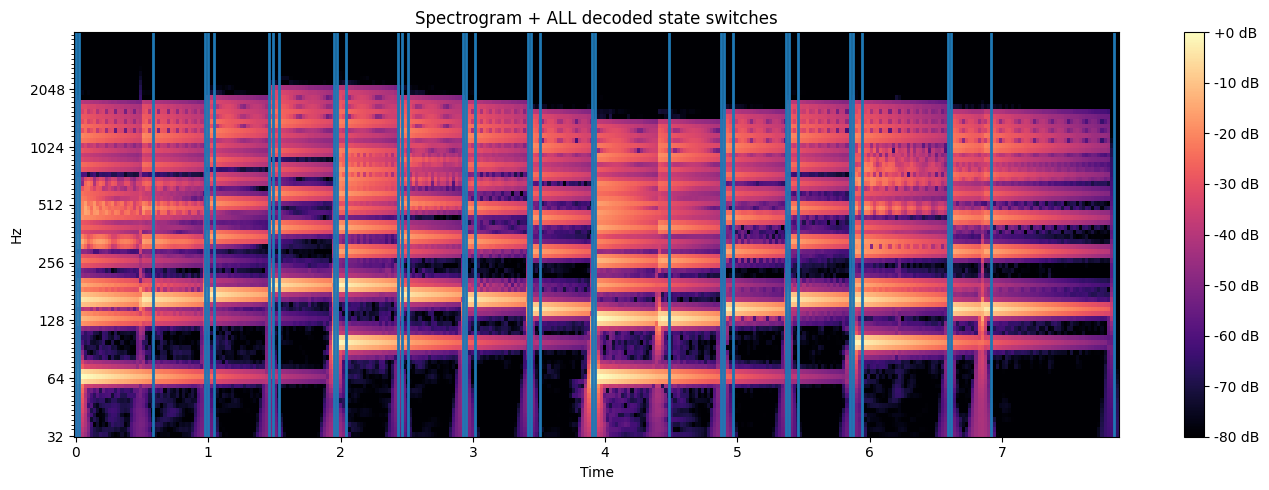

array([  0,   1,  25,  42,  43,  45,  63,  64,  66,  84,  85,  88, 105,
       106, 108, 126, 127, 130, 147, 148, 151, 168, 169, 193, 210, 211,
       214, 231, 232, 235, 252, 253, 256, 284, 285, 298, 338])

In [58]:
plot_spec_with_state_switches(C, sr, hop_length=512, path=path, title="Spectrogram + ALL decoded state switches", y_axis="cqt_hz")

In [56]:
print("C frames:", C.shape[1])
print("path frames:", len(path))

C frames: 340
path frames: 340
